In [1]:
import paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime
from database.models import Commit, ErrorLog, Project
from database.database import Database
from shared.calculation import average, calculate_ownership

database = Database(paths.DATABASE_PATH, cached=True)
results = {}
projects = database.query(Project.LABEL, where("log_groups") != [])

for project in projects:
    if not database.query(ErrorLog.LABEL, where("loggroup").one_of(project.log_groups)):
        continue

    commits = sorted(database.query(Commit.LABEL, where("project_id") == project.id), key=lambda x: x.timestamp)
    project_result = {}
    
    while commits:
        commit = commits.pop(-1)
        if (ownership := calculate_ownership(commits)):
            date = datetime.utcfromtimestamp(commit.timestamp).date().replace(day=1)
            if date not in project_result:
                project_result[date] = []
            project_result[date].append(ownership)
    
    if project_result:
        for date, result in project_result.items():
            project_result[date] = average(result)
        results[project.id] = project_result

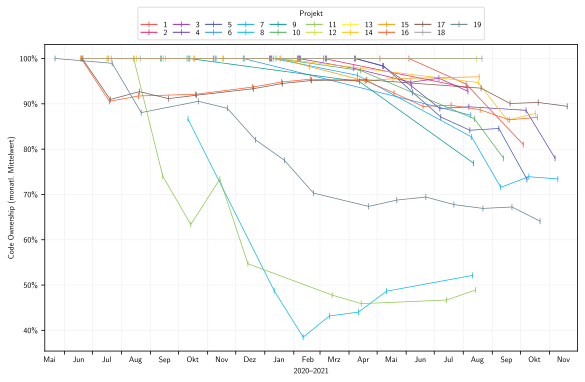

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTHEIGHT, locals.TEXTWIDTH * 0.9))

for index, result in enumerate(results.items()):
    project_id, project_results = result

    sorted_result = dict(sorted(project_results.items()))

    dates = [date.replace(day=int(index+4)) for date in sorted_result.keys()]
    values = list(sorted_result.values())

    ax.plot(dates, values, color=locals.PROJECTS[project_id]["color"],
        label=locals.PROJECTS[project_id]["id"], marker="|", markeredgewidth=0.7, linewidth=0.7)

legend = ax.legend(title="Projekt", loc="upper center", bbox_to_anchor=(0.5, 1.135),
    ncol=10, labelspacing=0.1, columnspacing=.75, edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_linewidth(1)
legend._legend_box.sep = 4

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment("center")

ax.margins(x=0.02)
ax.set_ylabel("Code Ownership (monatl. Mittelwert)")
ax.set_xlabel(f"2020–2021")
ax.grid(color=locals.GRID_GRAY)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()